In [1]:
# Install medcat
! pip install medcat==1.8.0
# install seaborn
! pip install seaborn
try:
    from medcat.cat import CAT
except:
    print("WARNING: Runtime will restart automatically and please run other cells thereafter.")
    exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 |████████████████████████████████| 133 kB 5.1 MB/s 
 |████████████████████████████████| 385 kB 46.1 MB/s 
 |████████████████████████████████| 281 kB 39.8 MB/s 
 |████████████████████████████████| 24.1 MB 2.1 MB/s 
 |████████████████████████████████| 121 kB 47.5 MB/s 
 |████████████████████████████████| 177 kB 16.2 MB/s 
 |████████████████████████████████| 212 kB 44.2 MB/s 
 |████████████████████████████████| 346 kB 48.5 MB/s 
 |████████████████████████████████| 115 kB 40.2 MB/s 
 |████████████████████████████████| 5.9 MB 44.4 MB/s 
 |████████████████████████████████| 9.9 MB 46.7 MB/s 
 |████████████████████████████████| 4.2 MB 42.8 MB/s 
 |████████████████████████████████| 86 kB 6.1 MB/s 
 |████████████████████████████████| 120 kB 33.3 MB/s 
 |████████████████████████████████| 245 kB 42.8 MB/s 
 |████████████████████████████████| 1.6 MB 47.0 MB/s 
 |████████████████████████████████| 1.6 

**Restart the runtime if on colab, sometimes necessary after installing models**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json 

from matplotlib import pyplot as plt
from medcat.cat import CAT

/usr/local/lib/python3.7/dist-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
 from tqdm.autonotebook import tqdm, trange


In [2]:
DATA_DIR = "./data_p5/"
! DATA_DIR="./data_p5/"
model_pack_path = DATA_DIR + "medmen_wstatus_2021_oct.zip"

### Download and load the data

In [3]:
# Download the models and required data
!wget -N https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/pt_notes.csv -P $DATA_DIR
!wget -N https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/MedCAT_Export.json -P $DATA_DIR
!wget -N https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/cui_location.json -P $DATA_DIR

!wget -N https://cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com/medcat-example-models/medmen_wstatus_2021_oct.zip -P $DATA_DIR

--2022-08-25 12:44:56-- https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/pt_notes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3644222 (3.5M) [text/plain]
Saving to: ‘./data/pt_notes.csv’

pt_notes.csv 100%[===================>] 3.47M --.-KB/s in 0.07s 

2022-08-25 12:44:56 (51.9 MB/s) - ‘./data/pt_notes.csv’ saved [3644222/3644222]

--2022-08-25 12:44:56-- https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/MedCAT_Export.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

In [4]:
# Load the cui_location dictionary
cui_location = json.load(open(DATA_DIR + "cui_location.json"))
# Load the pt_notes
data = pd.read_csv(DATA_DIR + "pt_notes.csv")
# Get the model
cat = CAT.load_model_pack(model_pack_path)

INFO:medcat:{
 "Model ID": null,
 "Last Modified On": null,
 "History (from least to most recent)": [],
 "Description": "No description",
 "Source Ontology": null,
 "Location": null,
 "MetaCAT models": {},
 "Basic CDB Stats": {},
 "Performance": {
 "ner": {},
 "meta": {}
 },
 "Important Parameters (Partial view, all available in cat.config)": {
 "config.ner['min_name_len']": {
 "value": 3,
 "description": "Minimum detection length (found terms/mentions shorter than this will not be detected)."
 },
 "config.ner['upper_case_limit_len']": {
 "value": 3,
 "description": "All detected terms shorter than this value have to be uppercase, otherwise they will be ignored."
 },
 "config.linking['similarity_threshold']": {
 "value": 0.2,
 "description": "If the confidence of the model is lower than this a detection will be ignore."
 },
 "config.general['spell_check']": {
 "value": true,
 "description": "Is spell checking enabled."
 },
 "config.general['spell_check_len_limit']": {
 "value": 7,
 "de

## Calculate the required maps

`CUI` - Disease identifier

`cui_subjects_cnts` - Used to calculate the number of occurances of a disease for a certain patient (in his text records). 

`cui_subjects` - Map from cui to patientId

`subject2gender` - Map from patientId to gender
`subject2agegroup` - Map from patientId to agegroup (defined [here](https://www.researchgate.net/publication/232746130_Automated_Medical_Literature_Retrieval)

`subject2age` - Map from patientId to age

`subject2cuis` - Map from patientId to list of CUIs

In [5]:
# We are only going to keep those subjects that have at least two appearances of a concept
cui_subjects_cnts = {}
cui_subjects = {}
subject2gender = {}
subject2agegroup = {}
subject2age = {}
subject2cuis = {}

for cui in cui_location:
    cui_subjects_cnts[cui] = {}
    cui_subjects[cui] = set()
    
     
    for location in cui_location[cui]:
        subject_id = data.iat[location, list(data.columns).index('subject_id')]
        gender  = data.iat[location, list(data.columns).index('gender')]
        age = data.iat[location, list(data.columns).index('age_year')]
        agegroup = "UNK"
        
        if subject_id not in subject2cuis:
            subject2cuis[subject_id] = set()

        subject2cuis[subject_id].add(cui)
        
        if age >= 13 and age <= 18:
            agegroup = 'Adolescent'
        elif age >= 19 and age <= 24:
            agegroup = "Young Adult"
        elif age >= 25 and age <= 44:
            agegroup = 'Adult'
        elif age >= 45 and age <= 64:
            agegroup = "Middle Aged"
        elif age >= 64:
            agegroup = "Aged"
        
        if subject_id in cui_subjects_cnts[cui]:
            cui_subjects_cnts[cui][subject_id] += 1
        else:
            cui_subjects_cnts[cui][subject_id] = 1

        if cui_subjects_cnts[cui][subject_id] == 2:
            cui_subjects[cui].add(subject_id)
            
            subject2gender[subject_id] = gender
            subject2agegroup[subject_id] = agegroup
            subject2age[subject_id] = age

# Calculate total number of patients in each group:

`pt_total` - Total number (all patients together)

`pt_male` - Number of male patients

`pt_female` - Number of female patients

`pt_adl` - Number of Adolescents

`pt_yadult` - Number of Young Adults

`pt_adult` - Number of Adults

`pt_maged` - Number of Middle Aged

`pt_aged` - Number of Aged

In [6]:
pt_total = len(subject2age)
pt_male = len([x for x in subject2gender if subject2gender[x] == "M"])
pt_female = len([x for x in subject2gender if subject2gender[x] == "F"])
pt_adl = len([x for x in subject2agegroup if subject2agegroup[x] == "Adolescent"])
pt_yadult = len([x for x in subject2agegroup if subject2agegroup[x] == "Young Adult"])
pt_adult = len([x for x in subject2agegroup if subject2agegroup[x] == "Adult"])
pt_maged = len([x for x in subject2agegroup if subject2agegroup[x] == "Middle Aged"])
pt_aged = len([x for x in subject2agegroup if subject2agegroup[x] == "Aged"])

### Create the header of our CSV that will contain all information for one disease

In [7]:
dt = [['disease', 'cui', 'tui', 'total', 'male', 'female', 'Adolescent', 'Young Adult', "Adult", "Middle Aged", "Aged"]]

### Fill the array with data

In [8]:
for cui in cui_subjects:
    d = cat.cdb.cui2preferred_name.get(cui, 'unk')
    t = (len(cui_subjects[cui]) / pt_total) * 100
    m = (len([x for x in cui_subjects[cui] if subject2gender[x] == 'M']) / pt_male) * 100
    f = (len([x for x in cui_subjects[cui] if subject2gender[x] == 'F']) / pt_female) * 100
    
    adl =  (len([x for x in cui_subjects[cui] if subject2agegroup[x] == 'Adolescent']) / pt_adl) * 100
    yadult =  (len([x for x in cui_subjects[cui] if subject2agegroup[x] == 'Young Adult']) / pt_yadult) * 100
    adult = (len([x for x in cui_subjects[cui] if subject2agegroup[x] == 'Adult']) / pt_adult) * 100
    maged = (len([x for x in cui_subjects[cui] if subject2agegroup[x] == 'Middle Aged']) / pt_maged) * 100
    aged = (len([x for x in cui_subjects[cui] if subject2agegroup[x] == 'Aged']) / pt_aged) * 100
    
    tui = cat.cdb.cui2type_ids.get(cui, 'unk')
    dt.append([d, cui, tui, t, m, f, adl, yadult, adult, maged, aged])
    #dt.append([d, cui, tui, t, m, f, adl, yadult, adult, maged, aged, m_adl, m_yadult, m_adult, m_maged, m_aged,
            #  f_adl, f_yadult, f_adult, f_maged, f_aged])

### Convert to dataframe

In [9]:
df = pd.DataFrame(dt[1:], columns=dt[0])
df = df.sort_values(by=['total'], ascending=True)
df.reset_index(drop=True, inplace=True)

# Plot top 30 diseases for the type T047: Physical Disorders

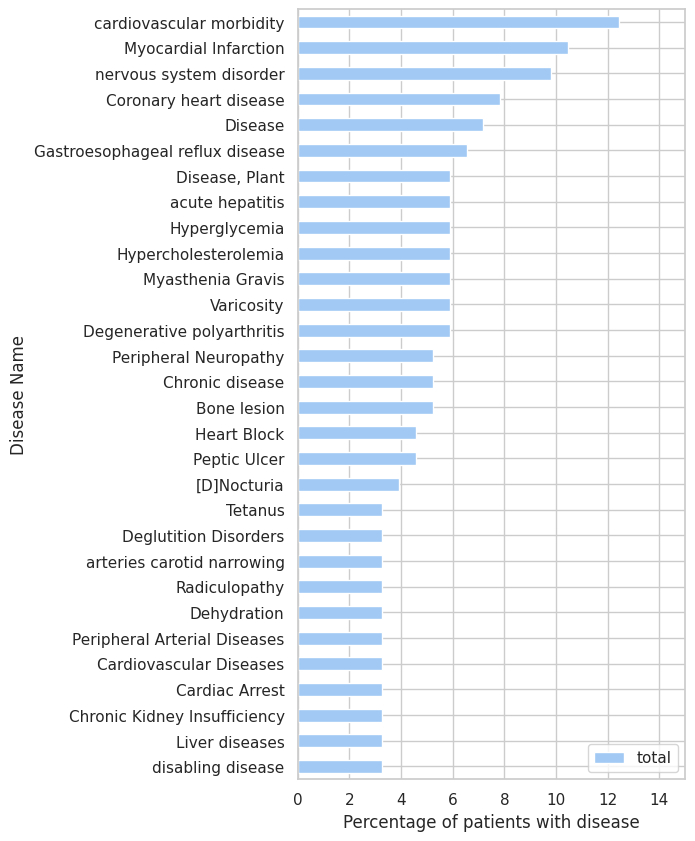

In [10]:
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(5,10)}, 
    style="whitegrid",
    palette='pastel'
)
# Subset the data and chose only T047, top 30
_data = df[df['tui'].apply(lambda x: 'T047' in x)].iloc[-30:]

# Create the plot
ax = _data.plot(y=['total'], x="disease", kind="barh")
# Legend position and label names
ax.legend(loc='lower right')
_ = ax.set(xlim=(0, 15), ylabel="Disease Name", xlabel="Percentage of patients with disease", )
# Show
plt.show()

End of tutorial 